In [133]:
import pandas as pd
import numpy as np
import datetime
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
data0 = pd.read_csv("data/1019_SP.csv").dropna()
data1 = pd.read_csv("data/1019_CL.csv").dropna()
data2 = pd.read_csv("data/1019_OVX.csv").dropna()
data3 = pd.read_csv("data/1019_GC.csv").dropna()
data4 = pd.read_csv("data/1019_GVZ.csv").dropna()
Date = data0.get("Date")
Date = pd.to_datetime(Date)
Close = data0.get("Close")
Close_cl = data1.get("Close")
Close_ovx = data2.get("Close")
Close_gc = data3.get("Close")
Close_gvz = data4.get("Close")
dict = {"Date": Date,
        "close": Close, 
        "close_cl": Close_cl, 
        "close_ovx": Close_ovx,
        "close_gc": Close_gc, 
        "close_gvz": Close_gvz,
       }
df = pd.DataFrame(dict)
df.set_index('Date', inplace=True)
df = df.dropna()
print("總共:%d個交易時間點" % (len(Date)))
print("去除空白值後剩下:%d個交易時間點" % (len(df)))
df.tail(10)

總共:2493個交易時間點
去除空白值後剩下:2493個交易時間點


,close,close_cl,close_ovx,close_gc,close_gvz
Date,,,,,
2019-12-13,3168.800049,60.070000,26.760000,1475.599976,10.39
2019-12-16,3191.449951,60.209999,26.510000,1475.000000,10.39
2019-12-17,3192.520020,60.939999,26.330000,1474.599976,10.03
2019-12-18,3191.139893,60.930000,26.770000,1472.599976,10.04
2019-12-19,3205.370117,61.220001,24.799999,1478.199951,10.39
2019-12-20,3221.219971,60.439999,25.540001,1474.699951,9.69
2019-12-23,3224.010010,60.520000,25.110001,1482.500000,10.56
2019-12-26,3239.909912,61.680000,24.080000,1509.300049,13.33
2019-12-27,3240.020020,61.720001,25.160000,1513.800049,12.32


In [ ]:
dataset = pd.DataFrame({
    'Close':df['close'],
    'Close_CL':df['close_cl'],
    'Close_OVX':df['close_ovx'],
    'Close_GC':df['close_gc'],
    'Close_GVZ':df['close_gvz'],
    'return': df['close'].shift(-10) / df['close'],
})

feature_names = list(dataset.columns[:-1])

In [135]:
print("before dropping NaN", dataset.shape)
dataset = dataset.dropna()
print("after dropping NaN", dataset.shape)

before dropping NaN (2493, 6)
after dropping NaN (2483, 6)


In [136]:
import lightgbm as lgb
dataset_train = dataset[:'2018']
dataset_test = dataset['2019':]

gbm = lgb.LGBMClassifier(n_estimators=100, random_state=5, learning_rate=0.01)

train = (dataset_train[feature_names], dataset_train['return'] > 1)
test = (dataset_test[feature_names], dataset_test['return'] > 1)

gbm.fit(*train)
gbm.score(*test)

0.42857142857142855

In [137]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

dataset_scaled = ss.fit_transform(dataset)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns, index=dataset.index)
dataset_scaled['return'] = dataset['return']
dataset_scaled.describe()

,Close,Close_CL,Close_OVX,Close_GC,Close_GVZ,return
count,2.483000e+03,2.483000e+03,2.483000e+03,2.483000e+03,2.483000e+03,2483.000000
mean,-6.050559e-16,1.696410e-16,9.018606e-17,1.744253e-16,6.536142e-16,1.004513
std,1.000201e+00,1.000201e+00,1.000201e+00,1.000201e+00,1.000201e+00,0.025844
min,-1.598298e+00,-2.111228e+00,-1.854236e+00,-1.648193e+00,-1.683902e+00,0.837023
25%,-9.893172e-01,-9.212425e-01,-6.518855e-01,-6.801764e-01,-7.562230e-01,0.991897
50%,4.600424e-02,-4.743239e-02,-1.326325e-01,-2.944210e-01,-9.477448e-02,1.006708
75%,8.110847e-01,9.584971e-01,5.460101e-01,4.530842e-01,5.511953e-01,1.020612
max,2.078457e+00,1.885155e+00,4.528270e+00,3.029437e+00,4.728331e+00,1.092456


In [138]:
n = 3

X = []
y = []
indexes = []
dataset_scaled_x = dataset_scaled[feature_names]

for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-n)):
    X.append(dataset_scaled_x.iloc[i:i+n].values)
    y.append(dataset_scaled['return'].iloc[i+n-1])
    indexes.append(dataset_scaled.index[i+n-1])

X = np.array(X)
y = np.array(y)
indexes = np.array(indexes)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
#2010~2018年為訓練和測試，2019年則為驗證
import datetime
X_train = X[indexes < datetime.datetime(2019, 1, 1)]
y_train = y[indexes < datetime.datetime(2019, 1, 1)]
x_validation = X[indexes > datetime.datetime(2019,1,1)]
y_validation = y[indexes > datetime.datetime(2019,1,1)]

In [140]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers

model = Sequential()
model.add(layers.LSTM(128, return_sequences=True, input_shape=cnn_x_train[0].shape))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(128))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=1, activation='linear'))

model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 20, 128)           68608     
_________________________________________________________________
dropout_26 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 204,353
Trainable params: 204,353
Non-trainable params: 0
_______________________________________________

In [141]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(X_train,y_train>1,
                    batch_size=100,
                    epochs=250,
                    verbose=1,
                    validation_split = 0.2,
                    #validation_data=(cnn_x_test,cnn_y_test),
                    #callbacks=[earlystop],
                    )

Epoch 1/250
18/18 [==============================] - 1s 41ms/step - loss: 1.4654 - accuracy: 0.3835 - val_loss: 1.8841 - val_accuracy: 0.3318
Epoch 2/250
18/18 [==============================] - 0s 7ms/step - loss: 0.7462 - accuracy: 0.5418 - val_loss: 1.1732 - val_accuracy: 0.3385
Epoch 3/250
18/18 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5725 - val_loss: 0.9754 - val_accuracy: 0.3363
Epoch 4/250
18/18 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.5847 - val_loss: 0.9088 - val_accuracy: 0.3385
Epoch 5/250
18/18 [==============================] - 0s 7ms/step - loss: 0.6857 - accuracy: 0.5658 - val_loss: 0.8636 - val_accuracy: 0.3363
Epoch 6/250
18/18 [==============================] - 0s 7ms/step - loss: 0.6796 - accuracy: 0.5853 - val_loss: 0.8009 - val_accuracy: 0.3385
Epoch 7/250
18/18 [==============================] - 0s 7ms/step - loss: 0.6672 - accuracy: 0.6065 - val_loss: 0.7895 - val_accuracy: 0.3363
Epoch 8/250


In [142]:
o_loss,o_accuracy = model.evaluate(cnn_x_train,cnn_y_train)
print("對訓練資料的：\nLoss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
n_loss,n_accuracy = model.evaluate(cnn_x_validation,cnn_y_validation)
print("對測試資料的：\nLoss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))

56/56 [==============================] - 0s 3ms/step - loss: 9.1598 - accuracy: 0.3753
對訓練資料的：
Loss: 9.16, Accuracy: 0.38
8/8 [==============================] - 0s 3ms/step - loss: 4.6365 - accuracy: 0.5424 
對測試資料的：
Loss: 4.64, Accuracy: 0.54


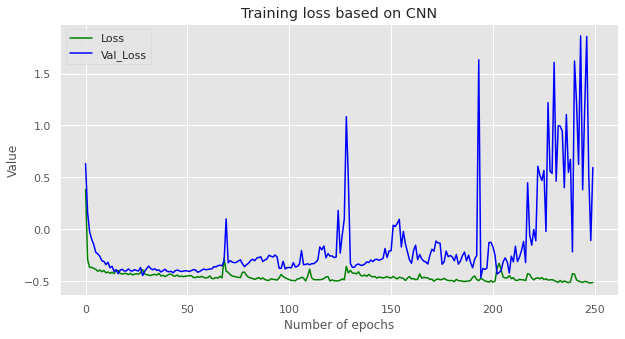

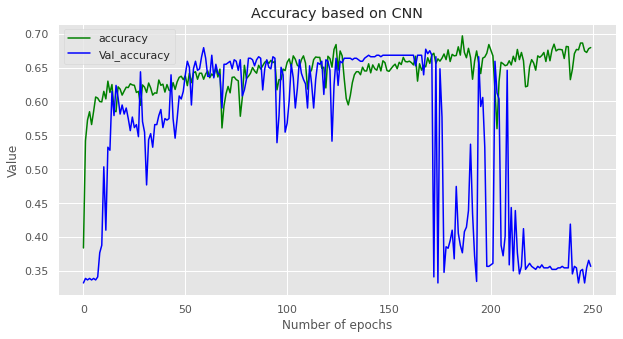

In [143]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.log(history.history['loss']), color = 'green', label='Loss')
plt.plot(np.log(history.history['val_loss']), color = 'blue', label='Val_Loss')
plt.legend()
plt.title('Training loss based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], color = 'green', label='accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label='Val_accuracy')
plt.legend()
plt.title('Accuracy based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()

In [ ]:
pre = model.predict(cnn_x_validation)
pre = pd.DataFrame(pre).values.astype(float)

In [ ]:
def updown(predict):
  data = []
  for i in range(len(cnn_y_validation)):
    if pre[i]>0.5:
      data.append(1)
    else:
      data.append(0)
  return data

In [ ]:
pre = np.array(updown(pre))

TP: 117.00, FN: 55.00, FP: 53.00, TN: 11.00
對訓練集資料的：Loss: 9.16, Accuracy: 0.38
對測試集資料的：Loss: 4.64, Accuracy: 0.54

測試資料總共：236.00 筆, 其中漲的筆數為: 172.00, 全部猜漲猜對的機率是: 0.73
該測試集資料的：
Accuracy: 0.54, Precision: 0.69, Recall: 0.68
F1 score: 0.68


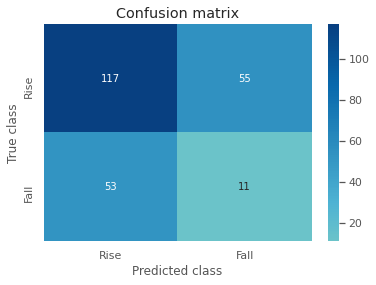

In [147]:
from sklearn.metrics import confusion_matrix


LABELS = ["Rise","Fall"]
conf_matrix = confusion_matrix(cnn_y_validation, pre)

t_size = len(cnn_y_validation)
t_size1 = (cnn_y_validation<1).sum()
t_guess = ((cnn_y_validation<1).sum())/(len(cnn_y_validation))

TP = conf_matrix[0][0]
FN = conf_matrix[0][1]
FP = conf_matrix[1][0]
TN = conf_matrix[1][1]
accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = 2*((precision*recall)/(precision+recall))
print("TP: %.2f, FN: %.2f, FP: %.2f, TN: %.2f" % (TP,FN,FP,TN))
print("對訓練集資料的：Loss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
print("對測試集資料的：Loss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))
print("\n測試資料總共：%.2f 筆, 其中漲的筆數為: %.2f, 全部猜漲猜對的機率是: %.2f" % (t_size, t_size1, t_guess))
print("該測試集資料的：\nAccuracy: %.2f, Precision: %.2f, Recall: %.2f\nF1 score: %.2f" % (accuracy, precision,recall,F1))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",center=0.7,cmap = 'GnBu');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()